# Anchor-free single-stage object detection with FCOS

In this exercise your goal will be to solve an object detection training and prediction task using the anchor-free single-stage approach.

There are 10 points to get in total.

## TLDR; overview

In this task one should:
- build an object detection model using the variant of `FCOS`,
- train an object detection model.

Hints and comments:

- Model architecture and loss are heavily inspired by [FCOS](https://arxiv.org/pdf/1904.01355.pdf) paper,
- you can freely subclass and extend the interface of classes in this exercise,
- be sure that you understand the concept of anchor-free object detection. There are many tutorials and articles about it (e.g. [this](https://medium.com/swlh/fcos-walkthrough-the-fully-convolutional-approach-to-object-detection-777f614268c) one).

### Data description

In this task we will paste bounding boxes with digits **from 1 to 5** randomly selected from `MNIST` dataset on a canvas of size `(128, 128)` and **randomly scaled by a factor between 0.5 and 1.0**. We assume that:

- the two boxes from a canvas should have no more than `0.1` of `iou` overlap,
- the digits are fully contained in canvas,
- boxes are modeled using `MnistBox` class,
- canvas is modeled using `MnistCanvas` class.

Let us have a look at definition of these classes:

In [576]:
from typing import List
from typing import Optional
from typing import Tuple

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import torch


DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class MnistBox:

    def __init__(
        self,
        x_min: int,
        y_min: int,
        x_max: int,
        y_max: int,
        class_nb: Optional[int] = None,
        rotated: Optional[bool] = None,
    ):
        self.x_min = x_min
        self.x_max = x_max
        self.y_min = y_min
        self.y_max = y_max
        self.class_nb = class_nb
        self.rotated = rotated
    
    @property
    def x_diff(self):
        return self.x_max - self.x_min
    
    @property
    def y_diff(self):
        return self.y_max - self.y_min

    def __repr__(self):
        return f'Mnist Box: x_min = {self.x_min},' +\
               f' x_max = {self.x_max}, y_min = {self.y_min},' +\
               f' y_max = {self.y_max}. Class = {self.class_nb}.' +\
               f' Rotated = {self.rotated}.'

    def plot_on_ax(self, ax, color: Optional[str] = 'r'):
        ax.add_patch(
            patches.Rectangle(
                (self.y_min, self.x_min),
                 self.y_diff,
                 self.x_diff,
                 linewidth=1,
                 edgecolor=color,
                 facecolor='none',
            )
        )
        ax.text(
            self.y_min,
            self.x_min,
            f'{self.class_nb}' if not self.rotated else f'{self.class_nb}*',
            bbox={"facecolor": color, "alpha": 0.4},
            clip_box=ax.clipbox,
            clip_on=True,
        )

    @property
    def area(self):
        return max((self.x_max - self.x_min), 0) * max((self.y_max - self.y_min), 0)

    def iou_with(self, other_box: "MnistBox"):
        aux_box = MnistBox(
            x_min=max(self.x_min, other_box.x_min),
            x_max=min(self.x_max, other_box.x_max),
            y_min=max(self.y_min, other_box.y_min),
            y_max=min(self.y_max, other_box.y_max),
        ) 
        return aux_box.area / (self.area + other_box.area - aux_box.area)


class MnistCanvas:

    def __init__(
        self,
        image: np.ndarray,
        boxes: List[MnistBox],
    ):
        self.image = image
        self.boxes = boxes
        self.shape = (1, 1, self.image.shape[0], self.image.shape[1])

    def add_digit(
        self,
        digit: np.ndarray,
        class_nb: int,
        x_min: int,
        y_min: int,
        rotated=None,
        iou_threshold=0.1,
    ) -> bool:
        """
        Add a digit to an image if it does not overlap with existing boxes
        above iou_threshold.
        """
        image_x, image_y = digit.shape
        if x_min >= self.image.shape[0] and y_min >= self.image.shape[1]:
            raise ValueError('Wrong initial corner box')
        new_box_x_min = x_min
        new_box_y_min = y_min
        new_box_x_max = min(x_min + image_x, self.image.shape[0])
        new_box_y_max = min(y_min + image_y, self.image.shape[1])
        new_box = MnistBox(
            x_min=new_box_x_min,
            x_max=new_box_x_max,
            y_min=new_box_y_min,
            y_max=new_box_y_max,
            class_nb=class_nb,
            rotated=rotated,
        )
        old_background = self.image[
            new_box_x_min:new_box_x_max,
            new_box_y_min:new_box_y_max
        ]
        for box in self.boxes:
            if new_box.iou_with(box) > iou_threshold:
                return False
        self.image[
            new_box_x_min:new_box_x_max,
            new_box_y_min:new_box_y_max
        ] = np.maximum(old_background, digit)
        self.boxes.append(
            new_box
        ) 
        return True
        
    def get_torch_tensor(self) -> torch.Tensor:
        np_image = self.image.astype('float32')
        np_image = np_image.reshape(
            (1, 1, self.image.shape[0], self.image.shape[1])
        )
        return torch.from_numpy(np_image).to(DEVICE)

    @classmethod
    def get_empty_of_size(cls, size: Tuple[int, int]):
        return cls(
            image=np.zeros(size),
            boxes=[],
        )

    def plot(self, boxes: Optional[List[MnistBox]] = None):
        fig, ax = plt.subplots()
        ax.imshow(self.image)
        boxes = boxes or self.boxes
        for box in boxes:
            box.plot_on_ax(ax)
        plt.show()

Each canvas has 3-6 boxes with randomly selected digits. The digits for training data are from first 10K examples from `MNIST` train data. The digits for test data are selected from first 1K examples from `MNIST` test data. The Dataset is generated using the following functions:

In [577]:
from keras.datasets import mnist
import numpy as np
import skimage.transform as st


mnist_data = mnist.load_data()
(mnist_x_train, mnist_y_train), (mnist_x_test, mnist_y_test) = mnist_data


def crop_insignificant_values(digit:np.ndarray, threshold=0.1):
    bool_digit = digit > threshold
    x_range = bool_digit.max(axis=0)
    y_range = bool_digit.max(axis=1)
    start_x = (x_range.cumsum() == 0).sum()
    end_x = (x_range[::-1].cumsum() == 0).sum()
    start_y = (y_range.cumsum() == 0).sum()
    end_y = (y_range[::-1].cumsum() == 0).sum()
    return digit[start_y:-end_y - 1, start_x:-end_x - 1]


TRAIN_DIGITS = [
    crop_insignificant_values(digit) / 255.0
    for digit_index, digit in enumerate(mnist_x_train[:10000])
]
TRAIN_CLASSES = mnist_y_train[:10000]

TEST_DIGITS = [
    crop_insignificant_values(digit) / 255.0
    for digit_index, digit in enumerate(mnist_x_test[:1000])
]
TEST_CLASSES = mnist_y_test[:1000]


def get_random_canvas(
    digits: Optional[List[np.ndarray]] = None,
    classes: Optional[List[int]] = None,
    nb_of_digits: Optional[int] = None,
    labels = [0, 1, 2, 3, 4]
    ):
    digits = digits if digits is not None else TRAIN_DIGITS
    classes = classes if classes is not None else TRAIN_CLASSES
    nb_of_digits = nb_of_digits if nb_of_digits is not None else np.random.randint(low=3, high=6 + 1)
    new_canvas = MnistCanvas.get_empty_of_size(size=(128, 128))
    attempts_done = 0
    while attempts_done < nb_of_digits:
        current_digit_index = np.random.randint(len(digits))
        current_digit_class = classes[current_digit_index]
        if current_digit_class not in labels:
            continue
        rescale = np.random.random() > 0.5
        current_digit = digits[current_digit_index]
        if rescale:
            factor = (np.random.random() / 2) + 0.5
            current_digit = st.resize(
                current_digit, 
                (int(current_digit.shape[0] * factor), int(current_digit.shape[1] * factor)))
            # current_digit = np.rot90(current_digit)
        random_x_min = np.random.randint(0, 128 - current_digit.shape[0] - 3)
        random_y_min = np.random.randint(0, 128 - current_digit.shape[1] - 3)
        if new_canvas.add_digit(
            digit=current_digit,
            x_min=random_x_min,
            y_min=random_y_min,
            class_nb=current_digit_class,
            rotated=rescale,
        ):
            attempts_done += 1
    return new_canvas

Let us have a look at example canvas (rescaled digits have additional *added to description).

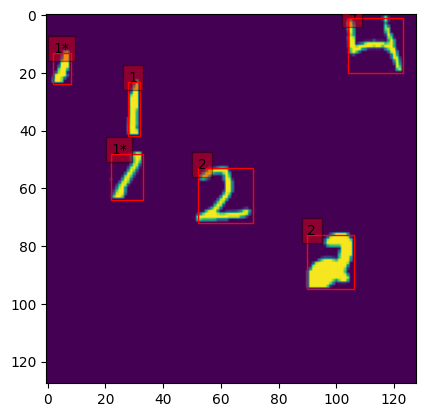

Mnist Box: x_min = 1, x_max = 20, y_min = 104, y_max = 123. Class = 4. Rotated = False.


In [578]:
mnist_canvas = get_random_canvas()
mnist_canvas.plot()
print(mnist_canvas.boxes[3])

For training one can either:
- generate `TRAIN_CANVAS` similarly to `TEST_CANVAS` creation,
- use the fact that `get_random_canvas()` generates a random train canvas and generate training data on-the-fly.

### Model building (5 pt.)


One should build a model for digit detection in $\texttt{pytorch}$. Model should consist of:

#### $\texttt{backbone}$:

We provided you with a backbone model architecture paired with Feature Pyramid Network (`BackboneWithFPN`) that accepts a `MnistCanvas` instance and output a dictionary, which has a FPN group name as a keys and their tensors as value.
For a FPN with strides set to [32, 64, 128] and number of output channels set to 64, the sizes of the tensors will be [1, 64, 128, 128], [1, 64, 64, 64], [1, 64, 32, 32] consecutively. This module should be trained together with the rest of your solution.

In [579]:
from collections import OrderedDict
from torch import nn, Tensor
from torchvision.ops.feature_pyramid_network import FeaturePyramidNetwork


class Backbone(torch.nn.Module):
    def __init__(self, strides = [8, 16, 32]):
        super().__init__()
        
        self.first_block = torch.nn.Sequential(
            nn.Conv2d(1, strides[0], (3, 3), padding=1),
            nn.ReLU(),
        )
        
        self.blocks = torch.nn.ModuleList(
            [torch.nn.Sequential(*[
                nn.Conv2d(strides[i-1], strides[i], (3, 3), padding=1),
                nn.ReLU(),
                nn.MaxPool2d(2, 2),
              ]) for i in range(1, len(strides))
            ]
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        image = x.to(DEVICE).view(1, 1, 128, 128)
        x = self.first_block(image)
        aux = [x]
        for block in self.blocks:
            x = block(aux[-1])
            aux.append(x)
        return aux


class BackboneWithFPN(torch.nn.Module):
    def __init__(self, strides, out_channels=32) -> None:
        super().__init__()
        self.strides = strides
        self.out_channels = out_channels
        self.backbone = Backbone(self.strides)
        self.fpn = FeaturePyramidNetwork(self.strides, self.out_channels)

    def forward(self, x: torch.Tensor):
        output_backbone = self.backbone(x)
        
        x = OrderedDict()
        for i, f in enumerate(output_backbone):
            x[f'feat{i}'] = f
        output_fpn = self.fpn(x)
        return output_fpn

#### $\texttt{anchor generator}$:

FCOS is anchor-free in a typical sense of this word, but it can also be said that there is one pixel-wise "anchor" per localisation on a given feature map.
Therefore, anchor generator from `torchvision` is used for convenience.
You will obtain $128^2 + 64^2 + 32^2 = 21504$ locations in total for the previously chosen strides.
They will be called anchors in the code.

In [580]:
# example code - anchor generator is already included in the code later
from torchvision.models.detection.anchor_utils import AnchorGenerator

anchor_sizes = ((32,), (64,), (128,))  # equal to strides of FPN multi-level feature map
aspect_ratios = ((1.0,),) * len(anchor_sizes)  # set only one anchor for each level
anchor_generator = AnchorGenerator(anchor_sizes, aspect_ratios)
anchor_generator.num_anchors_per_location()
# notice that effectively one anchor is one location

[1, 1, 1]

In [581]:
# Later in the code you will use the anchor generator in the following way:
# anchors = anchor_generator(images, features)
# [x.size(2) * x.size(3) for x in features] # recover level sizes

#### $\texttt{FCOSClassificationHead}$ (1 pt.):

Write a classification head to be used in FCOS.
The input is is the output of `BackboneWithFPN` forward call.
This module should contain $n$ blocks with `nn.Conv2d`, `nn.GroupNorm`, and `nn.ReLU` each (in the paper, $n=4$).
Each convolutional layer should input and output `self.out_channels` channels.
The additional final block should be `nn.Conv2d` outputting `C` channels.
The final output should consist of classification logits of shape `(N, A, C)`, where `N` means the number of samples in a batch, `A` is the sum of all FPN strides (21504 in the aforementioned case), and `C` is the number of classes.

In [582]:
CLASS_HEAD_KERNEL_SIZE = 1
CLASS_HEAD_NUM_GROUPS = 8

class FCOSClassificationHead(nn.Module):
    def __init__(
        self,
        in_channels: int,
        num_classes: int,
        num_convs: int = 4,
    ) -> None:
        super().__init__()

        # TODO: your code here
        ################################################################################################

        # Helped myself with: https://pytorch.org/vision/main/_modules/torchvision/models/detection/fcos.html

        self.in_channels = in_channels
        self.num_classes = num_classes
        self.num_convs = num_convs

        blocks = []
        for _ in range(self.num_convs):
            blocks.append(nn.Conv2d(in_channels, in_channels, kernel_size=CLASS_HEAD_KERNEL_SIZE))
            blocks.append(nn.GroupNorm(CLASS_HEAD_NUM_GROUPS, in_channels))
            blocks.append(nn.ReLU())

        self.blocks = nn.Sequential(*blocks)

        self.last_block = nn.Sequential(
            nn.Conv2d(in_channels=self.in_channels, out_channels=self.num_classes, kernel_size=CLASS_HEAD_KERNEL_SIZE)
        )

        ################################################################################################
        # end of your code

    def forward(self, x: List[Tensor]) -> Tensor:
        # TODO: your code here
        ################################################################################################
        mylist = []

        for feature in x:
            myx = feature
            myx = self.blocks(myx)

            myx = self.last_block(myx)
            N, _ , H, W = myx.shape
            myx = myx.view(N, -1, self.num_classes, H, W).permute(0, 3, 4, 1, 2).reshape(N, -1, self.num_classes)
            mylist.append(myx)


        result = torch.cat(mylist, dim=1)
        return result
        
        ################################################################################################
        # end of your code


#### $\texttt{FCOSRegressionHead}$  (1 pt.):

Write a regression head to be used in FCOS - both for bounding boxes and center-ness.
The input is the output of `BackboneWithFPN` forward call.
This module should contain $n$ blocks with `nn.Conv2d`, `nn.GroupNorm`, and `nn.ReLU` each (in the paper, $n=4$), which will be shared for regression and center-ness.
The final block for bounding box regression should be `nn.Conv2d` and have `4` channels and it should be followed by relu functional to get rid of negative values.
The final block for center-ness regression should be `nn.Conv2d` and have `1` channel.
The output should consist of a tuple of tensors (bounding box regression and center-ness).
Bounding box regression logits should be of shape `(N, A, 4)`, whereas for center-ness that would be `(N, A, 1)`.
Similarly, `N` means the number of samples in a batch, `A` is the sum of all FPN strides (21504 in the aforementioned case), and `C` is the number of classes.

In [583]:
REGRESSION_HEAD_KERNEL_SIZE = (3, 3)
REG_HEAD_NUM_ANCHORS = 1
REG_HEAD_NUM_GROUPS = 8

class FCOSRegressionHead(nn.Module):
    def __init__(
        self,
        in_channels: int,
        num_convs: int = 4,
    ):
        super().__init__()

        # TODO: your code here
        ################################################################################################
        # Helped myself with: https://pytorch.org/vision/main/_modules/torchvision/models/detection/fcos.html
        
        self.norm_layer = partial(nn.GroupNorm, 32)
        blocks = []
        for _ in range(num_convs):
          blocks.append(nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1))
          blocks.append(nn.GroupNorm(REG_HEAD_NUM_GROUPS, in_channels))
          blocks.append(nn.ReLU())

        self.blocks = nn.Sequential(*blocks)

        self.bbox_reg = nn.Sequential(
            nn.Conv2d(in_channels, REG_HEAD_NUM_ANCHORS * 4, kernel_size = REGRESSION_HEAD_KERNEL_SIZE, stride = 1, padding = 1),
            nn.ReLU()
        )
        self.bbox_ctrness = nn.Sequential(
            nn.Conv2d(in_channels, REG_HEAD_NUM_ANCHORS * 1, kernel_size = REGRESSION_HEAD_KERNEL_SIZE, stride = 1, padding = 1),
            nn.ReLU()
        )
        # end of your code
        ################################################################################################
        

    def forward(self, x: List[Tensor]) -> Tuple[Tensor, Tensor]:
        # TODO: your code here
        ################################################################################################

        regbox_list = []
        ctrbox_list = []

        for feature in x:
            myx = feature
            myx = self.blocks(myx)

            ## Regression
            bbox_regression = self.bbox_reg(myx)
            N, _, H, W = bbox_regression.shape
            regbox = bbox_regression.view(N, -1, 4, H, W)
            regbk=ox = regbox.permute(0, 3, 4, 1, 2)
            regbox = regbox.reshape(N, -1, 4)
            regbox_list.append(regbox)

            # Centerness
            bbox_ctrness = self.bbox_ctrness(myx)
            N, _, H, W = bbox_ctrness.shape
            ctrbox = bbox_ctrness.view(N, -1, 1, H, W)
            ctrbox = ctrbox.permute(0, 3, 4, 1, 2)
            ctrbox = ctrbox.reshape(N, -1, 1)
            ctrbox_list.append(ctrbox)

        reg_result = torch.cat(regbox_list, dim=1)
        ctr_result = torch.cat(ctrbox_list, dim=1)

        return reg_result, ctr_result
        ################################################################################################
        # end of your code

#### $\texttt{FCOSHead}$ (2 pt.):

Here, the computation of the foreground indices and losses takes place.

##### Loss calculation
Compute the losses. 
They should be calculated on the positive locations/anchors, so use the foreground mask from the previous excercise.
For regression, use `self.box_coder.decode_single` and `self.box_coder.decode_single` to move between standard (x, y, x, y) and FCOS (l, t, r, b) bounding box format.
There are three losses to be written.
- classification loss (with `torchvision.ops.sigmoid_focal_loss`). (1 pt.)
- Bounding box regression (with `torchvision.ops.generalized_box_iou_loss`). Decode predictions with `self.box_coder.decode_single` before regressing against the ground truth. (1 pt.)
- ctrness loss (`torchvision.ops.sigmoid_focal_loss`). Use Equation 3 from the paper to calculate the grond truth for the center-ness. (2 pt.)

In [584]:
from collections import OrderedDict
from functools import partial
from typing import Dict, List, Tuple, Optional

import torch
from torch import nn, Tensor

from torchvision.ops import sigmoid_focal_loss, generalized_box_iou_loss
from torchvision.ops import boxes as box_ops
from torchvision.models.detection.transform import GeneralizedRCNNTransform

class FCOSHead(nn.Module):
    """
    A regression and classification head for use in FCOS.

    Args:
        in_channels (int): number of channels of the input feature
        num_classes (int): number of classes to be predicted
        num_convs (Optional[int]): number of conv layer of head. Default: 4.
    """
    def __init__(self, in_channels: int, num_classes: int, num_convs: Optional[int] = 4) -> None:
        super().__init__()
        self.box_coder = BoxLinearCoder(normalize_by_size=True)
        self.classification_head = FCOSClassificationHead(in_channels, num_classes, num_convs)
        self.regression_head = FCOSRegressionHead(in_channels, num_convs)

    def compute_loss(
        self,
        targets: List[Dict[str, Tensor]],
        head_outputs: Dict[str, Tensor],
        anchors: List[Tensor],             # anchors/locations
        matched_idxs: List[Tensor],        # tells to which bounding box anchors are matched, -1 mean no matches
    ) -> Dict[str, Tensor]:

        cls_logits = head_outputs["cls_logits"]  # [N, A, C]
        bbox_regression = head_outputs["bbox_regression"]  # [N, A, 4]
        bbox_ctrness = head_outputs["bbox_ctrness"]  # [N, A, 1]
        all_gt_classes_targets = []
        all_gt_boxes_targets = []

        # print("TARGETS before computing: ", targets)
        # print("IDX before computing: ", matched_idxs) # [3 0 0 0 1]
        for targets_per_image, matched_idxs_per_image in zip(targets, matched_idxs):
            gt_classes_targets = targets_per_image["labels"][matched_idxs_per_image.clip(min=0)]
            gt_boxes_targets = targets_per_image["boxes"][matched_idxs_per_image.clip(min=0)]
            gt_classes_targets[matched_idxs_per_image < 0] = -1  # background
            all_gt_classes_targets.append(gt_classes_targets)
            all_gt_boxes_targets.append(gt_boxes_targets)

        all_gt_classes_targets = torch.stack(all_gt_classes_targets)
        # print(all_gt_classes_targets.shape)
        # print("ALL GT CLASSES TARGETS: ", all_gt_classes_targets)
        foregroud_mask = all_gt_classes_targets >= 0        
        num_foreground = foregroud_mask.sum().item()
        
        loss_cls = self.compute_loss_cls(cls_logits, all_gt_classes_targets, foregroud_mask)
        loss_bbox_reg = self.compute_loss_bbox_reg(anchors, bbox_regression, all_gt_boxes_targets, foregroud_mask)
        loss_bbox_ctrness = self.compute_loss_ctrness(anchors, bbox_ctrness, all_gt_boxes_targets, foregroud_mask)

        return {
            "classification": loss_cls / max(1, num_foreground),
            "bbox_regression": loss_bbox_reg / max(1, num_foreground),
            "bbox_ctrness": loss_bbox_ctrness / max(1, num_foreground),
        }

    def compute_loss_ctrness(self, anchors, bbox_ctrness, all_gt_boxes_targets, foreground_mask):
        # pass # TODO: your code here
        # print("anchors: ", len(anchors))  ### 1
        # print("ANCHOR SIZE", anchors[0].shape) ### [1, 21504, 4]
        # print("przyklad anchora: ", anchors[0])
        # print("bbox centerness: ", bbox_ctrness.shape)   ### torch.Size([1, 21504, 1])
        # print("BBOX przyklad ", bbox_ctrness)
        # print("All gt boxes: ", len(all_gt_boxes_targets))   ### 1
        # print("gt box shape: ", all_gt_boxes_targets[0].shape)  ### torch.Size([21504, 4]) # X1 Y1 X2 Y2
        # print("Foreground mask: ",foreground_mask.shape)  ### torch.Size([1, 21504])
        #
        # print("anchorsy: ", anchors[0])
        # print(all_gt_boxes_targets[0])
        ################################################################################################
        ## ctrness loss (torchvision.ops.sigmoid_focal_loss). Use Equation 3 from the paper to calculate the grond truth for the center-ness. (2 pt.)

        # self.box_coder.
        # print("Moj shape: ", all_gt_boxes_targets[foreground_mask].shape)
        # print(all_gt_boxes_targets.shape)
        # print(bbox_ctrness)

        # reference_boxes (Tensor): reference boxes
        # proposals (Tensor): boxes to be encoded

        bbox_reg_targets = self.box_coder.encode_single(torch.stack(anchors)[foreground_mask], torch.stack(all_gt_boxes_targets)[foreground_mask])
        if len(bbox_reg_targets) == 0:
            gt_ctrness_targets = bbox_reg_targets.new_zeros(bbox_reg_targets.size())
        else:
            left_right = bbox_reg_targets[:,:,[0,2]]
            top_bottom = bbox_reg_targets[:,:,[1,2]]
            gt_ctrness_targets = torch.sqrt(
                (left_right.min(dim=-1)[0] / left_right.max(dim=-1)[0]) * (top_bottom.min(dim=-1)[0] / top_bottom.min(dim=-1)[0])
            )

        pred_centerness = bbox_ctrness.squeeze(dim=2)
        loss_bbox_ctrness = nn.functional.binary_cross_entropy_with_logits(pred_centerness[foreground_mask], gt_ctrness_targets[foreground_mask], reduction="sum")
        return loss_bbox_ctrness
        # bbox_reg_targets = self.box_coder.encode_single(torch.stack(anchors)[foreground_mask], all_gt_boxes_targets[foreground_mask])
        # if len(bbox_reg_targets) == 0:
        #     gt_ctrness_targets = bbox_reg_targets.new_zeros(bbox_reg_targets)


        ################################################################################################

    def compute_loss_bbox_reg(self, anchors, bbox_regression, all_gt_boxes_targets, foreground_mask):
        # pass # TODO: your code here
        # regression loss: GIoU loss
        ################################################################################################

        boxes = self.box_coder.decode_single(bbox_regression[foreground_mask], torch.stack(anchors)[foreground_mask])
        ret = generalized_box_iou_loss(boxes, torch.stack(all_gt_boxes_targets)[foreground_mask], reduction="sum")
        print ("REGRESSION LOSS: ", ret)
        return ret
        ################################################################################################

    def compute_loss_cls(self, cls_logits, all_gt_classes_targets, foreground_mask):


        foreground_cls_logits = cls_logits[foreground_mask]
        one_hot_encoded_foreground_targets = torch.nn.functional.one_hot(all_gt_classes_targets[foreground_mask].long(), cls_logits.size(-1))
        ret = sigmoid_focal_loss(foreground_cls_logits, one_hot_encoded_foreground_targets.float(), reduction="sum")
        print ("CLASSIFICATION LOSS, ", ret)
        return ret

    def forward(self, x: List[Tensor]) -> Dict[str, Tensor]:
        cls_logits = self.classification_head(x)
        bbox_regression, bbox_ctrness = self.regression_head(x)
        return {
            "cls_logits": cls_logits,
            "bbox_regression": bbox_regression,
            "bbox_ctrness": bbox_ctrness,
        }

In [585]:
class BoxLinearCoder:
    """
    The linear box-to-box transform defined in FCOS. The transformation is parameterized
    by the distance from the center of (square) src box to 4 edges of the target box.
    """

    def __init__(self, normalize_by_size: bool = True) -> None:
        """
        Args:
            normalize_by_size (bool): normalize deltas by the size of src (anchor) boxes.
        """
        self.normalize_by_size = normalize_by_size

    def encode_single(self, reference_boxes: Tensor, proposals: Tensor) -> Tensor:
        """
        Encode a set of proposals with respect to some reference boxes

        Args:
            reference_boxes (Tensor): reference boxes
            proposals (Tensor): boxes to be encoded

        Returns:
            Tensor: the encoded relative box offsets that can be used to
            decode the boxes.
        """
        # get the center of reference_boxes
        reference_boxes_ctr_x = 0.5 * (reference_boxes[:, 0] + reference_boxes[:, 2])
        reference_boxes_ctr_y = 0.5 * (reference_boxes[:, 1] + reference_boxes[:, 3])

        # get box regression transformation deltas
        target_l = reference_boxes_ctr_x - proposals[:, 0]
        target_t = reference_boxes_ctr_y - proposals[:, 1]
        target_r = proposals[:, 2] - reference_boxes_ctr_x
        target_b = proposals[:, 3] - reference_boxes_ctr_y

        targets = torch.stack((target_l, target_t, target_r, target_b), dim=1)
        if self.normalize_by_size:
            reference_boxes_w = reference_boxes[:, 2] - reference_boxes[:, 0]
            reference_boxes_h = reference_boxes[:, 3] - reference_boxes[:, 1]
            reference_boxes_size = torch.stack(
                (reference_boxes_w, reference_boxes_h, reference_boxes_w, reference_boxes_h), dim=1
            )
            targets = targets / reference_boxes_size

        return targets

    def decode_single(self, rel_codes: Tensor, boxes: Tensor) -> Tensor:
        """
        From a set of original boxes and encoded relative box offsets,
        get the decoded boxes.

        Args:
            rel_codes (Tensor): encoded boxes
            boxes (Tensor): reference boxes.

        Returns:
            Tensor: the predicted boxes with the encoded relative box offsets.
        """

        boxes = boxes.to(rel_codes.dtype)

        ctr_x = 0.5 * (boxes[:, 0] + boxes[:, 2])
        ctr_y = 0.5 * (boxes[:, 1] + boxes[:, 3])
        if self.normalize_by_size:
            boxes_w = boxes[:, 2] - boxes[:, 0]
            boxes_h = boxes[:, 3] - boxes[:, 1]
            boxes_size = torch.stack((boxes_w, boxes_h, boxes_w, boxes_h), dim=1)
            rel_codes = rel_codes * boxes_size

        pred_boxes1 = ctr_x - rel_codes[:, 0]
        pred_boxes2 = ctr_y - rel_codes[:, 1]
        pred_boxes3 = ctr_x + rel_codes[:, 2]
        pred_boxes4 = ctr_y + rel_codes[:, 3]
        pred_boxes = torch.stack((pred_boxes1, pred_boxes2, pred_boxes3, pred_boxes4), dim=1)
        return pred_boxes

#### Post-processing (1 pt.)
Fill the gaps in the postprocessing routine.
The paper states: 

> (...) the final score (used for ranking the detected bounding boxes) 
> is computed by multiplying the predicted center-ness with the corresponding classification score. 
> Thus the center-ness can downweight the scores of bounding boxes far from the center of an object. 
> As a result, with high probability, these low-quality bounding boxes might be filtered out by 
> the final non-maximum suppression (NMS) process, improving the detection performance remarkably.

1. Remove boxes with score smaller than `self.score_thresh`. The score is given by `sqrt`($\sigma$(`classification_score`) * $\sigma$(`cente-ness_score`)) (1pt.)
2. Keep only top `self.topk_candidates` scoring predictions (1pt.)

The `compute_loss` function here calculates the indexes of matched classes for each anchor/location for your convenience in later calculations.

In [586]:
class FCOS(nn.Module):

    def __init__(
        self,
        backbone: nn.Module,
        num_classes: int,
        # transform parameters
        image_mean: Optional[List[float]] = None,
        image_std: Optional[List[float]] = None,
        # Anchor parameters
        anchor_generator: AnchorGenerator = None,
        center_sampling_radius: float = 1.5,
        score_thresh: float = 0.2,
        nms_thresh: float = 0.6,
        detections_per_img: int = 100,
        topk_candidates: int = 1000,
        num_convs_in_heads:int = 4,
        **kwargs,
    ):
        super().__init__()

        self.backbone = backbone
        self.anchor_generator = anchor_generator
        self.head = FCOSHead(backbone.out_channels, num_classes, num_convs=num_convs_in_heads)
        self.box_coder = BoxLinearCoder(normalize_by_size=True)
        self.transform = GeneralizedRCNNTransform(128, 128, image_mean, image_std, **kwargs)

        self.center_sampling_radius = center_sampling_radius
        self.score_thresh = score_thresh
        self.nms_thresh = nms_thresh
        self.detections_per_img = detections_per_img
        self.topk_candidates = topk_candidates


    def compute_loss(
        self,
        targets: List[Dict[str, Tensor]],
        head_outputs: Dict[str, Tensor],
        anchors: List[Tensor],
        num_anchors_per_level: List[int],
    ) -> Dict[str, Tensor]:
        matched_idxs = []
        for anchors_per_image, targets_per_image in zip(anchors, targets): # batch
            if targets_per_image["boxes"].numel() == 0:
                matched_idxs.append(
                    torch.full((anchors_per_image.size(0),), -1, dtype=torch.int64, device=anchors_per_image.device)
                )
                continue

            gt_boxes = targets_per_image["boxes"]
            gt_centers = (gt_boxes[:, :2] + gt_boxes[:, 2:]) / 2  # Nx2                 # Calculate centres of bounding boxes
            anchor_centers = (anchors_per_image[:, :2] + anchors_per_image[:, 2:]) / 2  # N  
            anchor_sizes = anchors_per_image[:, 2] - anchors_per_image[:, 0]            # Match anchors
            # center sampling: anchor point must be close enough to gt center.
            pairwise_match = (anchor_centers[:, None, :] - gt_centers[None, :, :]).abs_().max(
                dim=2
            ).values < self.center_sampling_radius * anchor_sizes[:, None]
            # compute pairwise distance between N points and M boxes
            x, y = anchor_centers.unsqueeze(dim=2).unbind(dim=1)  # (N, 1)
            x0, y0, x1, y1 = gt_boxes.unsqueeze(dim=0).unbind(dim=2)  # (1, M)
            pairwise_dist = torch.stack([x - x0, y - y0, x1 - x, y1 - y], dim=2)  # (N, M)

            # anchor point must be inside gt
            pairwise_match &= pairwise_dist.min(dim=2).values > 0

            # each anchor is only responsible for certain scale range.
            lower_bound = anchor_sizes * 4
            lower_bound[: num_anchors_per_level[0]] = 0
            upper_bound = anchor_sizes * 8
            upper_bound[-num_anchors_per_level[-1] :] = float("inf")
            pairwise_dist = pairwise_dist.max(dim=2).values
            pairwise_match &= (pairwise_dist > lower_bound[:, None]) & (pairwise_dist < upper_bound[:, None])

            # match the GT box with minimum area, if there are multiple GT matches
            gt_areas = (gt_boxes[:, 2] - gt_boxes[:, 0]) * (gt_boxes[:, 3] - gt_boxes[:, 1])  # N
            pairwise_match = pairwise_match.to(torch.float32) * (1e8 - gt_areas[None, :])
            min_values, matched_idx = pairwise_match.max(dim=1)  # R, per-anchor match
            matched_idx[min_values < 1e-5] = -1  # unmatched anchors are assigned -1

            matched_idxs.append(matched_idx)
        # end of your code
        # matched index - anchor-to-target match
        return self.head.compute_loss(targets, head_outputs, anchors, matched_idxs)

    def postprocess_detections(
        self, head_outputs: Dict[str, List[Tensor]], anchors: List[List[Tensor]], image_shapes: List[Tuple[int, int]]
    ) -> List[Dict[str, Tensor]]:
        class_logits = head_outputs["cls_logits"]
        box_regression = head_outputs["bbox_regression"]
        box_ctrness = head_outputs["bbox_ctrness"]

        pass # TODO: your code here
        num_images = len(image_shapes)

        detections: List[Dict[str, Tensor]] = []

        for index in range(num_images):
            box_regression_per_image = [br[index] for br in box_regression]
            logits_per_image = [cl[index] for cl in class_logits]
            box_ctrness_per_image = [bc[index] for bc in box_ctrness]
            anchors_per_image, image_shape = anchors[index], image_shapes[index]

            image_boxes = []
            image_scores = []
            image_labels = []

            for box_regression_per_level, logits_per_level, box_ctrness_per_level, anchors_per_level in zip(
                box_regression_per_image, logits_per_image, box_ctrness_per_image, anchors_per_image
            ):
                num_classes = logits_per_level.shape[-1]
                
                pass # TODO: your code here
                # Remove low scoring boxes and keep only topk scoring predictions
                ################################################################################################

                # scores_per_level = ...
                # topk_idxs = ...

                ################################################################################################
                # end of your code
                anchor_idxs = torch.div(topk_idxs, num_classes, rounding_mode="floor")
                labels_per_level = topk_idxs % num_classes

                boxes_per_level = self.box_coder.decode_single(
                    box_regression_per_level[anchor_idxs], anchors_per_level[anchor_idxs]
                )
                boxes_per_level = box_ops.clip_boxes_to_image(boxes_per_level, image_shape)

                image_boxes.append(boxes_per_level)
                image_scores.append(scores_per_level)
                image_labels.append(labels_per_level)

            image_boxes = torch.cat(image_boxes, dim=0)
            image_scores = torch.cat(image_scores, dim=0)
            image_labels = torch.cat(image_labels, dim=0)

            # non-maximum suppression
            keep = box_ops.batched_nms(image_boxes, image_scores, image_labels, self.nms_thresh)
            keep = keep[: self.detections_per_img]

            detections.append(
                {
                    "boxes": image_boxes[keep],
                    "scores": image_scores[keep],
                    "labels": image_labels[keep],
                }
            )
        return detections


    def forward(
        self,
        images: List[Tensor],
        targets: Optional[List[Dict[str, Tensor]]] = None,
    ) -> Tuple[Dict[str, Tensor], List[Dict[str, Tensor]]]:
        """
        Args:
            images (list[Tensor]): images to be processed
            targets (list[Dict[Tensor]]): ground-truth boxes present in the image (optional)

        Returns:
            result (list[BoxList] or dict[Tensor]): the output from the model.
                During training, it returns a dict[Tensor] which contains the losses.
                During testing, it returns list[BoxList] contains additional fields
                like `scores`, `labels` and `mask` (for Mask R-CNN models).
        """
        
        # transform the input (normalise with std and )
        images, targets = self.transform(images, targets)
        # print("Targets in transform: ", targets[0])
        # get the features from the backbone
        features = self.backbone(images.tensors)
        if isinstance(features, torch.Tensor):
            features = OrderedDict([("0", features)])
        features = list(features.values())

        # compute the fcos heads outputs using the features
        head_outputs = self.head(features)

        # create the set of anchors
        anchors = self.anchor_generator(images, features)
        # recover level sizes
        num_anchors_per_level = [x.size(2) * x.size(3) for x in features]
        
        losses = {}
        detections: List[Dict[str, Tensor]] = []
        if self.training:
            losses = self.compute_loss(targets, head_outputs, anchors, num_anchors_per_level)
            return losses
        else:
            # split outputs per level
            split_head_outputs: Dict[str, List[Tensor]] = {}
            for k in head_outputs:
                split_head_outputs[k] = list(head_outputs[k].split(num_anchors_per_level, dim=1))
            split_anchors = [list(a.split(num_anchors_per_level)) for a in anchors]

            # compute the detections
            detections = self.postprocess_detections(split_head_outputs, split_anchors, images.image_sizes)
            return detections

### Metrics and evaluation (2 pt.)

#### Digit Accuracy (1 pt.)

This method shoud accept `canvas: MnistCanvas` and `predicted_boxes: List[MnistBox]` obtained using `TargetDecoder.get_predictions` method and output whether there is a direct matching between boxes from `MnistCanvas` and predictions. There is a direct matching if:

- for all boxes from `canvas`, there exist precisely one box from `predicted_boxes` with a matching class, rotation and `iou` overlap greater than `0.5`,
- the number of `canvas` boxes match `len(predicted_boxes)`.

The method shoud output `1` if there is a matching and `0` otherwise.

#### Evaluation function (1 pt.)

Write an evaluation function for your model.
If needed, perform the final NMS with `torchvision.ops.nms` (threshold at `iou`) and remove redundant boxes with scores smaller than `min_score`.
Then, calculate the average `DigitAccuracy` for each.
You may experiment with parameters for this method, but the default ones are fine (this is not subject of our grading).
If you are fine what you achiveded with `postprocess_detections`, you may focus solely on evaluation (although playing with this second stage NMS and score thresholding might be useful for diagnostics).

The output of the method is the average digit accuracy on the test set. 
Use it to track your model performance over epochs.


In [587]:
class DigitAccuracy:
    def compute_metric  (
        self,
        predicted_boxes: List[MnistBox],
        canvas: MnistCanvas,
        iou: float = 0.5,
    ):
        # TODO: your code here
        ################################################################################################
        pass
        
        ################################################################################################
        # end of your code

def evaluate(model: nn.Module, TEST_CANVAS, min_score: float = .2, iou: float = .05) -> float:
    # TODO: your code here
    ################################################################################################
    pass

    ################################################################################################
    # end of your code

### Train your model (3pt)

One should use all classes defined above to train the model.

- Train the model. A passing threshold is `10%` of a `DigitAccuracy` on a `TEST_CANVAS` data (2 pt.).
- Plot example results of matched and mismatched predictions (0.5 pt.).
- Plot particular losses and evaluation score per (0.5 pt.).

**Hint:** Training can take a while to achieve the expected accuracy. It is normal that for many epochs at the beginning accuracy is constantly $0$. Do not worry as long as the loss is on average decreasing across epochs. You may want to reduce number of digit classes (for example only to generate `0`s on canvas) to test the convergence (the hyperparameters might change, though!). A model with around 500k parameters should be able to hit 10% of the metric in 20 minutes (tested on a 2021 MacBook on CPU). On Google Colab with GPU it will be matter of 2 minutes, but notice that the free GPU is limited.

**Even more important hint:** Pay attention to the ordering of the X/Y values of `get_torch_tensor` and align it with your target!

Good luck and have fun!

In [588]:
import torch.optim as optim
import torch
import torchvision
import pandas as pd

TEST_SEED = 42 # DO NOT CHANGE THIS LINE.
np.random.seed(TEST_SEED)

N_TRAINING_EXAMPLES = 500
LR = 0.0004 # for SGD with momentum=0.9
EPOCHS = 16
STRIDES = [32, 64, 128]
CONVS_IN_HEADS = 4
OUT_CHANNELS = 64
LABELS = list(range(5))  # lower it for quick convergence testing
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

TRAIN_CANVAS = [
    get_random_canvas(
        digits=TEST_DIGITS,
        classes=TEST_CLASSES,
        labels=LABELS,
    )
    for _ in range(N_TRAINING_EXAMPLES)
]

TEST_CANVAS_SIZE = 256


TEST_CANVAS = [
    get_random_canvas(
        digits=TEST_DIGITS,
        classes=TEST_CLASSES,
        labels=LABELS,
    )
    for _ in range(TEST_CANVAS_SIZE)
]

anchor_sizes = tuple([(x,) for x in STRIDES])  # equal to strides of multi-level feature map
aspect_ratios = ((1.0,),) * len(anchor_sizes)  # set only one "anchor" per location
anchor_generator = AnchorGenerator(anchor_sizes, aspect_ratios)

fcos = FCOS(
    backbone = BackboneWithFPN(strides=STRIDES, out_channels=OUT_CHANNELS), 
    num_classes = len(LABELS), 
    image_mean = [0.0233],
    image_std = [0.14],
    num_convs_in_heads = CONVS_IN_HEADS, 
    anchor_generator = anchor_generator,
    detections_per_img = 100
    )
fcos.to(DEVICE)

# TODO: write your code here
################################################################################################

train_tensors_images = [canva.get_torch_tensor() for canva in TRAIN_CANVAS]
tens = train_tensors_images[0]
# print(tens.shape)

# train_tensors_images = tr

for e in range(EPOCHS):
    for image in TRAIN_CANVAS:
        # print(image)
        tensor_image = image.get_torch_tensor()

        box_list = []
        label_list = []
        for box in image.boxes:
            x1 = box.x_min
            x2 = box.x_max
            y1 = box.y_min
            y2 = box.y_max
            box_list.append([x1, y1, x2, y2])
            label_list.append(box.class_nb)
        print ("lista boxów do dania: ", box_list)
        print("lista labelek do dania: ", label_list)
        targets = [{
            "boxes": torch.Tensor(box_list).to(DEVICE),
            "labels": torch.Tensor(label_list).to(DEVICE)
        }]
        # fcos(tensor_image)
        fcos(tensor_image, targets)
        # fcos(tensor_image, [{"boxes": torch.Tensor([[x0, y0, x1, y1]]).to(DEVICE), "labels": torch.Tensor([class]).to(DEVICE)}])



################################################################################################

lista boxów do dania:  [[102, 82, 117, 94], [99, 103, 118, 106], [87, 107, 97, 109], [20, 32, 39, 36], [88, 48, 97, 55]]
lista labelek do dania:  [3, 1, 1, 1, 0]
CLASSIFICATION LOSS,  tensor(252.7172, device='cuda:0', grad_fn=<SumBackward0>)
REGRESSION LOSS:  tensor(301.0756, device='cuda:0', grad_fn=<SumBackward0>)
GT CTRNESS TARGETS  torch.Size([301])
FOREGROUND MASK  torch.Size([1, 21504])
LOSS_BBOX_CTRNESS:  tensor(212.3362, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
lista boxów do dania:  [[61, 46, 72, 57], [54, 63, 73, 82], [50, 6, 69, 9], [3, 88, 22, 98], [46, 34, 65, 37]]
lista labelek do dania:  [4, 3, 1, 1, 1]
CLASSIFICATION LOSS,  tensor(498.5719, device='cuda:0', grad_fn=<SumBackward0>)
REGRESSION LOSS:  tensor(657.7802, device='cuda:0', grad_fn=<SumBackward0>)
GT CTRNESS TARGETS  torch.Size([658])
FOREGROUND MASK  torch.Size([1, 21504])
LOSS_BBOX_CTRNESS:  tensor(475.7096, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>

KeyboardInterrupt: 

In [ ]:
# tensorek = torch.Tensor([[0, 0, 4, 4]]).to(DEVICE)
# x0, y0, x1, y1 = tensorek.unsqueeze(dim=0).unbind(dim=2)  # (1, M)
# print(tensorek)
# print(x0, y0, x1, y1)
